# Brain Tumor Object Detection using Hybrid CNN–Attention Architecture

This notebook implements a complete object detection pipeline for Brain tumor detection
using medical images. The model is built entirely from scratch and consists of:

- Custom CNN backbone (ResNet + EfficientNet hybrid)
- Multi-Head Self-Attention modules
- Feature Pyramid Network (FPN)
- Custom detection head
- Hand-written loss, training, evaluation, and inference


## `Install Dependencies`

In [ ]:
!pip install roboflow

## `Import Libraries`

In [ ]:
import os
import json
import cv2
import torch
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import albumentations as A

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

from roboflow import Roboflow
from torch.utils.data import Dataset, DataLoader

from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR
from torch.optim.lr_scheduler import ChainedScheduler, ReduceLROnPlateau

## `Download Dataset (Roboflow)`

In [ ]:
rf = Roboflow(api_key="A0JN8vO130atlzhwM2JN")
project = rf.workspace("ayyub-alzahem").project("brain-tumor-aeizh")
version = project.version(6)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to BRAIN-TUMOR-6 in yolov8:: 100%|██████████| 6138/6138 [00:00<00:00, 7770.44it/s] 


## `Dataset Class`

In [ ]:
class BrainTumorDataset(Dataset):
    """
    Custom PyTorch Dataset for loading brain tumor images and bounding box labels.

    Labels are expected in YOLO format:
        class_id center_x center_y width height
        (all normalized between 0 and 1)
    """

    def __init__(self, root, split="train", img_size=256):
        """
        Args:
            root (str): Root directory of the dataset.
            split (str): Dataset split ("train", "val", or "test").
            img_size (int): Target image size (images resized to img_size x img_size).
        """
        # Paths to image and label folders
        self.img_dir = os.path.join(root, split, "images")
        self.label_dir = os.path.join(root, split, "labels")
        self.img_size = img_size

        # Collect and sort all image filenames
        self.images = sorted([
            f for f in os.listdir(self.img_dir)
            if f.endswith((".jpg", ".png", ".jpeg"))
        ])

        # Image transformations: resize and convert to tensor
        self.transform = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor()
        ])

    def __len__(self):
        """Return the total number of images in the dataset."""
        return len(self.images)

    def __getitem__(self, idx):
        """
        Load one image and its corresponding target.

        Args:
            idx (int): Index of the sample.

        Returns:
            image (Tensor): Image tensor of shape [3, H, W].
            target (dict): Dictionary containing:
                - boxes (Tensor): Bounding boxes in (x1, y1, x2, y2) format.
                - labels (Tensor): Class labels for each bounding box.
        """
        # Get image filename and paths
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        label_path = os.path.join(
            self.label_dir, img_name.replace(".jpg", ".txt")
        )

        # Load image and apply transformations
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        boxes, labels = [], []

        # Load label file if it exists
        if os.path.exists(label_path):
            with open(label_path) as f:
                for line in f:
                    # Read YOLO-format annotation
                    cls, cx, cy, w, h = map(float, line.split())

                    # Convert from YOLO format to (x1, y1, x2, y2)
                    x1 = (cx - w / 2) * self.img_size
                    y1 = (cy - h / 2) * self.img_size
                    x2 = (cx + w / 2) * self.img_size
                    y2 = (cy + h / 2) * self.img_size

                    boxes.append([x1, y1, x2, y2])
                    labels.append(int(cls))

        # Return image and target dictionary (PyTorch detection format)
        return image, {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.long)
        }


def collate_fn(batch):
    """
    Custom collate function for object detection models.

    This keeps images and targets as lists instead of stacking tensors,
    which is required for models like Faster R-CNN.
    """
    imgs, tgts = zip(*batch)
    return list(imgs), list(tgts)

## `Create Datasets & DataLoaders`

In [ ]:
root = "BRAIN-TUMOR-6"

## Loading the Data & re-formatting & Splitting Data
train_dataset = BrainTumorDataset(root, split="train")
val_dataset   = BrainTumorDataset(root, split="valid")
test_dataset  = BrainTumorDataset(root, split="test")

## Loading the Data Into DataLoader.
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn
)

In [ ]:
img, target = train_dataset[0]
print(img.shape)
print(target["boxes"].min(), target["boxes"].max())

torch.Size([3, 256, 256])
tensor(106.) tensor(144.4583)


## `Visualize Sample Data`

In [ ]:
def visualize_sample(dataset, idx=0, class_names=None):
    """
    Visualize a dataset sample with bounding box annotations.

    Args:
        dataset: PyTorch dataset
        idx (int): Index of sample to visualize
        class_names (list or dict): Optional class name mapping
    """
    image, target = dataset[idx]

    # Convert tensor image to numpy (H, W, C)
    image = image.permute(1, 2, 0).cpu().numpy()

    boxes = target["boxes"].cpu().numpy()
    labels = target["labels"].cpu().numpy()

    fig, ax = plt.subplots(1, figsize=(7, 7))
    ax.imshow(image)
    ax.axis("off")

    for box, label in zip(boxes, labels):
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min

        rect = patches.Rectangle(
            (x_min, y_min),
            width,
            height,
            linewidth=2,
            edgecolor="red",
            facecolor="none"
        )
        ax.add_patch(rect)

        if class_names is not None:
            class_name = (
                class_names[label]
                if isinstance(class_names, list)
                else class_names.get(label, str(label))
            )
            ax.text(
                x_min,
                max(y_min - 5, 0),
                class_name,
                color="yellow",
                fontsize=10,
                bbox=dict(facecolor="black", alpha=0.5)
            )
        else:
            ax.text(
                x_min,
                max(y_min - 5, 0),
                f"ID: {label}",
                color="yellow",
                fontsize=10,
                bbox=dict(facecolor="black", alpha=0.5)
            )

    plt.show()

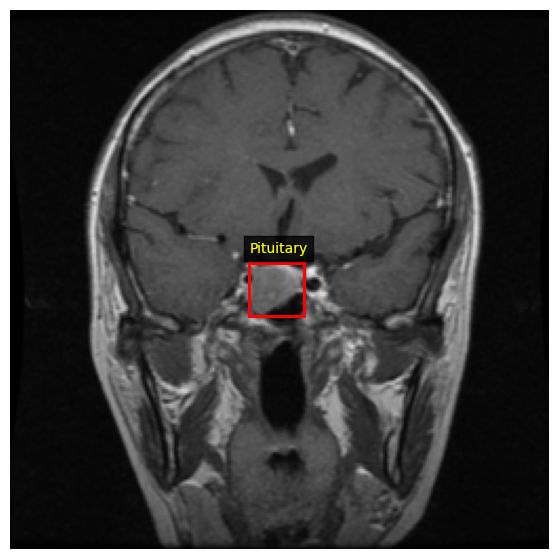

In [ ]:
class_names = ["Glioma", "Meningioma", "Pituitary"]

visualize_sample(
    dataset=train_dataset,
    idx=random.randint(0, len(train_dataset) - 1),
    class_names=class_names
)

## `Backbone Building Blocks`

In [ ]:
## Base Model
class ConvBNAct(nn.Module):
    """
    Basic convolutional block:
    Convolution → Batch Normalization → ReLU activation
    """

    def __init__(self, in_ch, out_ch, k=3, s=1, p=1):
        """
        Args:
            in_ch (int): Number of input channels.
            out_ch (int): Number of output channels.
            k (int): Kernel size.
            s (int): Stride.
            p (int): Padding.
        """
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, k, s, p, bias=False)
        self.bn = nn.BatchNorm2d(out_ch)
        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        """Apply Conv → BN → ReLU."""
        return self.act(self.bn(self.conv(x)))


## ResNet Block
class ResidualBlock(nn.Module):
    """
    Residual block used in ResNet architectures.
    Includes a skip connection to improve gradient flow.
    """

    def __init__(self, in_ch, out_ch, stride=1):
        """
        Args:
            in_ch (int): Number of input channels.
            out_ch (int): Number of output channels.
            stride (int): Stride for spatial downsampling.
        """
        super().__init__()

        # First convolution (may downsample)
        self.conv1 = ConvBNAct(in_ch, out_ch, 3, stride, 1)

        # Second convolution (no activation here)
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_ch)
        )

        # Identity shortcut by default
        self.shortcut = nn.Identity()

        # Projection shortcut if shape changes
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 1, stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )

        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        """
        Forward pass with residual connection.
        """
        out = self.conv1(x)
        out = self.conv2(out)
        out += self.shortcut(x)  # Add skip connection
        return self.act(out)


## Efficient Block
class MBConvBlock(nn.Module):
    """
    Mobile Inverted Bottleneck Convolution (MBConv) block.
    Used in EfficientNet-like architectures.
    """

    def __init__(self, in_ch, out_ch, expansion=4, stride=1):
        """
        Args:
            in_ch (int): Number of input channels.
            out_ch (int): Number of output channels.
            expansion (int): Channel expansion ratio.
            stride (int): Stride for depthwise convolution.
        """
        super().__init__()

        # Expanded channel size
        mid = in_ch * expansion

        # Pointwise expansion
        self.expand = ConvBNAct(in_ch, mid, 1, 1, 0)

        # Depthwise convolution
        self.depthwise = nn.Sequential(
            nn.Conv2d(mid, mid, 3, stride, 1, groups=mid, bias=False),
            nn.BatchNorm2d(mid),
            nn.ReLU(inplace=True)
        )

        # Pointwise projection
        self.project = nn.Sequential(
            nn.Conv2d(mid, out_ch, 1, bias=False),
            nn.BatchNorm2d(out_ch)
        )

        # Residual connection condition
        self.use_res = stride == 1 and in_ch == out_ch

    def forward(self, x):
        """
        Forward pass with optional residual connection.
        """
        out = self.project(self.depthwise(self.expand(x)))
        return out + x if self.use_res else out


## Multi Head Attention
class MultiHeadSelfAttention(nn.Module):
    """
    Multi-Head Self-Attention block for 2D feature maps.
    Allows global context modeling across spatial dimensions.
    """

    def __init__(self, dim, heads=4):
        """
        Args:
            dim (int): Number of input channels.
            heads (int): Number of attention heads.
        """
        super().__init__()

        # Generate query, key, and value tensors
        self.qkv = nn.Conv2d(dim, dim * 3, 1, bias=False)

        # Output projection
        self.proj = nn.Conv2d(dim, dim, 1)

        self.heads = heads
        self.scale = (dim // heads) ** -0.5  # Scaling factor for stability

    def forward(self, x):
        """
        Forward pass of multi-head self-attention.

        Args:
            x (Tensor): Input feature map of shape (B, C, H, W).

        Returns:
            Tensor: Output feature map with attention applied.
        """
        B, C, H, W = x.shape

        # Compute Q, K, V and reshape for multi-head attention
        qkv = self.qkv(x).reshape(
            B, 3, self.heads, C // self.heads, H * W
        )
        q, k, v = qkv[:, 0], qkv[:, 1], qkv[:, 2]

        # Scaled dot-product attention
        attn = torch.matmul(q.transpose(-2, -1), k) * self.scale
        attn = attn.softmax(dim=-1)

        # Apply attention to values
        out = torch.matmul(attn, v.transpose(-2, -1))
        out = out.transpose(-2, -1).reshape(B, C, H, W)

        # Final projection + residual connection
        return self.proj(out) + x

## `Hybrid Attention Backbone`

In [ ]:
class HybridAttentionBackbone(nn.Module):
    """
    Hybrid CNN–Attention backbone network.

    Combines:
    - Convolutional blocks (Residual + MBConv)
    - Multi-Head Self-Attention for global context modeling

    Outputs multi-scale feature maps for detection or segmentation heads.
    """

    def __init__(self):
        """
        Initializes the backbone stages.
        Each stage downsamples spatial resolution while increasing channels.
        """
        super().__init__()

        # Stem: initial feature extraction and downsampling
        self.stem = ConvBNAct(3, 32, 3, 2, 1)

        # Stage 1: Residual block + attention
        self.stage1 = nn.Sequential(
            ResidualBlock(32, 64, 2),
            MultiHeadSelfAttention(64)
        )

        # Stage 2: MBConv block + attention
        self.stage2 = nn.Sequential(
            MBConvBlock(64, 128, 4, 2),
            MultiHeadSelfAttention(128)
        )

        # Stage 3: Residual block + attention
        self.stage3 = nn.Sequential(
            ResidualBlock(128, 256, 2),
            MultiHeadSelfAttention(256)
        )

        # Stage 4: MBConv block + attention
        self.stage4 = nn.Sequential(
            MBConvBlock(256, 512, 6, 2),
            MultiHeadSelfAttention(512)
        )

    def forward(self, x):
        """
        Forward pass through the backbone.

        Args:
            x (Tensor): Input image tensor of shape (B, 3, H, W).

        Returns:
            list[Tensor]: List of feature maps at different scales.
        """
        feats = []

        # Initial stem
        x = self.stem(x)

        # Progressive feature extraction
        x = self.stage1(x)
        feats.append(x)

        x = self.stage2(x)
        feats.append(x)

        x = self.stage3(x)
        feats.append(x)

        x = self.stage4(x)
        feats.append(x)

        return feats

## `Feature Pyramid Network (FPN)`

In [ ]:
class FPN(nn.Module):
    """
    Feature Pyramid Network (FPN).

    Builds a top-down feature pyramid with lateral connections
    to combine high-level semantic information with low-level
    spatial details.
    """

    def __init__(self, in_ch):
        """
        Args:
            in_ch (list[int]): Number of channels for backbone feature maps
                               [C2, C3, C4, C5].
        """
        super().__init__()

        # Lateral 1x1 convolutions to unify channel dimensions
        self.lat = nn.ModuleList([
            nn.Conv2d(c, 256, 1) for c in in_ch
        ])

        # Output 3x3 convolutions to refine fused features
        self.out = nn.ModuleList([
            nn.Conv2d(256, 256, 3, 1, 1) for _ in in_ch
        ])

    def forward(self, feats):
        """
        Forward pass of the FPN.

        Args:
            feats (list[Tensor]): Backbone feature maps [C2, C3, C4, C5].

        Returns:
            list[Tensor]: Pyramid features [P2, P3, P4, P5].
        """
        # Unpack backbone features
        C2, C3, C4, C5 = feats

        # Top-down pathway with lateral connections
        P5 = self.lat[3](C5)
        P4 = self.lat[2](C4) + F.interpolate(P5, scale_factor=2, mode="nearest")
        P3 = self.lat[1](C3) + F.interpolate(P4, scale_factor=2, mode="nearest")
        P2 = self.lat[0](C2) + F.interpolate(P3, scale_factor=2, mode="nearest")

        # Apply output convolutions for smoothing
        P5 = self.out[3](P5)
        P4 = self.out[2](P4)
        P3 = self.out[1](P3)
        P2 = self.out[0](P2)

        return [P2, P3, P4, P5]

In [ ]:
class AnchorGenerator:
    """
    Anchor box generator for anchor-based object detection models.

    Generates anchors of different aspect ratios at each spatial
    location of a feature map.
    """

    def __init__(self, size=32, ratios=[0.5, 1.0, 2.0]):
        """
        Args:
            size (int): Base size (scale) of the anchor boxes.
            ratios (list[float]): Aspect ratios (width / height).
        """
        self.size = size
        self.ratios = ratios

    def generate(self, H, W, stride, device):
        """
        Generate anchor boxes for a given feature map size.

        Args:
            H (int): Feature map height.
            W (int): Feature map width.
            stride (int): Stride of the feature map relative to the input image.
            device (torch.device): Device to place the tensors on.

        Returns:
            Tensor: Anchor boxes of shape (H * W * num_ratios, 4)
                    in (x1, y1, x2, y2) format.
        """
        # Compute grid center positions in the original image space
        shifts_x = torch.arange(W, device=device) * stride
        shifts_y = torch.arange(H, device=device) * stride
        yy, xx = torch.meshgrid(shifts_y, shifts_x, indexing="ij")
        xx, yy = xx.reshape(-1), yy.reshape(-1)

        anchors = []

        # Generate anchors for each aspect ratio
        for r in self.ratios:
            # Compute width and height for the given ratio
            w = self.size * torch.sqrt(torch.tensor(r, device=device))
            h = self.size / torch.sqrt(torch.tensor(r, device=device))

            # Create anchor boxes centered at each grid location
            anchors.append(torch.stack([
                xx - w / 2, yy - h / 2,
                xx + w / 2, yy + h / 2
            ], dim=1))

        # Stack anchors: [H*W, num_ratios, 4]
        anchors = torch.stack(anchors, dim=1)

        # Flatten to [H*W*num_ratios, 4]
        return anchors.reshape(-1, 4)

## `IoU + Encoding`

In [ ]:
def box_iou(a, b):
    """
    Compute pairwise Intersection over Union (IoU) between two sets of boxes.

    Args:
        a (Tensor): Bounding boxes of shape (N, 4).
        b (Tensor): Bounding boxes of shape (M, 4).

    Returns:
        Tensor: IoU matrix of shape (N, M).
    """
    # Compute left-top and right-bottom corners of intersection
    lt = torch.max(a[:, None, :2], b[:, :2])
    rb = torch.min(a[:, None, 2:], b[:, 2:])

    # Compute intersection width and height
    wh = (rb - lt).clamp(min=0)
    inter = wh[:, :, 0] * wh[:, :, 1]

    # Compute individual box areas
    area1 = (a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1])
    area2 = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])

    # Compute IoU
    return inter / (area1[:, None] + area2 - inter + 1e-6)


def encode_boxes(gt, anc):
    """
    Encode ground-truth boxes relative to anchor boxes.

    Uses center-offset and log-scale encoding commonly used
    in anchor-based object detectors.

    Args:
        gt (Tensor): Ground-truth boxes of shape (N, 4).
        anc (Tensor): Anchor boxes of shape (N, 4).

    Returns:
        Tensor: Encoded box offsets of shape (N, 4).
    """
    # Anchor centers and sizes
    ax = (anc[:, 0] + anc[:, 2]) / 2
    ay = (anc[:, 1] + anc[:, 3]) / 2
    aw = anc[:, 2] - anc[:, 0]
    ah = anc[:, 3] - anc[:, 1]

    # Ground-truth centers and sizes
    gx = (gt[:, 0] + gt[:, 2]) / 2
    gy = (gt[:, 1] + gt[:, 3]) / 2
    gw = gt[:, 2] - gt[:, 0]
    gh = gt[:, 3] - gt[:, 1]

    # Encode offsets and scales
    return torch.stack([
        (gx - ax) / aw,
        (gy - ay) / ah,
        torch.log(gw / aw),
        torch.log(gh / ah)
    ], dim=1)


def assign_targets(anchors, gt_boxes, gt_labels):
    """
    Assign classification labels and matched ground-truth boxes to anchors.

    Label convention:
        -1 : ignore
         0 : background
        >0 : foreground class (gt_label + 1)

    Args:
        anchors (Tensor): Anchor boxes of shape (A, 4).
        gt_boxes (Tensor): Ground-truth boxes of shape (G, 4).
        gt_labels (Tensor): Ground-truth class labels of shape (G,).

    Returns:
        labels (Tensor): Anchor labels of shape (A,).
        matched_boxes (Tensor): Matched GT boxes for each anchor (A, 4).
    """
    # Initialize all anchors as ignored
    labels = torch.full(
        (anchors.size(0),), -1, device=anchors.device
    )
    matched = torch.zeros_like(anchors)

    # Handle images with no ground-truth boxes
    if gt_boxes.numel() == 0:
        labels[:] = 0  # all background
        return labels, matched

    # Compute IoU between anchors and ground-truth boxes
    ious = box_iou(anchors, gt_boxes)

    # For each anchor, find best-matching GT box
    mi, idx = ious.max(dim=1)

    # Assign background labels
    labels[mi < 0.4] = 0

    # Assign positive labels
    pos = mi >= 0.5
    labels[pos] = gt_labels[idx[pos]] + 1

    # Store matched GT boxes
    matched = gt_boxes[idx]

    return labels, matched

## `Detection Head`

In [ ]:
class DetectionHead(nn.Module):
    """
    Detection head for anchor-based object detection.

    Predicts:
    - Bounding box regression offsets
    - Class scores
    - Objectness scores

    Operates on multi-scale FPN feature maps.
    """

    def __init__(self, num_classes, num_anchors=3):
        """
        Args:
            num_classes (int): Number of object classes.
            num_anchors (int): Number of anchors per spatial location.
        """
        super().__init__()

        # Shared convolutional layers for feature refinement
        self.conv = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU()
        )

        # Bounding box regression head (x, y, w, h)
        self.box = nn.Conv2d(256, num_anchors * 4, 1)

        # Classification head
        self.cls = nn.Conv2d(256, num_anchors * num_classes, 1)

        # Objectness confidence head
        self.obj = nn.Conv2d(256, num_anchors, 1)

        self.na = num_anchors
        self.nc = num_classes

    def forward(self, feats):
        """
        Forward pass of the detection head.

        Args:
            feats (list[Tensor]): Feature maps from FPN
                                  [P2, P3, P4, P5].

        Returns:
            boxes (list[Tensor]): Box predictions per level
                Shape: (B, A, 4, H, W)
            clss (list[Tensor]): Class predictions per level
                Shape: (B, A, C, H, W)
            objs (list[Tensor]): Objectness predictions per level
                Shape: (B, A, 1, H, W)
        """
        B = feats[0].shape[0]

        boxes, clss, objs = [], [], []

        # Apply detection head to each FPN level
        for f in feats:
            x = self.conv(f)
            H, W = x.shape[-2:]

            # Bounding box regression
            boxes.append(
                self.box(x).view(B, self.na, 4, H, W)
            )

            # Class logits
            clss.append(
                self.cls(x).view(B, self.na, self.nc, H, W)
            )

            # Objectness scores
            objs.append(
                self.obj(x).view(B, self.na, 1, H, W)
            )

        return boxes, clss, objs

## `Full Detector Model`

In [ ]:
class BrainTumorDetector(nn.Module):
    """
    End-to-end brain tumor detection model.

    Architecture:
        Input Image
            → HybridAttentionBackbone
            → Feature Pyramid Network (FPN)
            → Detection Head (box, class, objectness)
    """

    def __init__(self, num_classes):
        """
        Args:
            num_classes (int): Number of tumor classes to detect.
        """
        super().__init__()

        # Backbone for hierarchical feature extraction
        self.backbone = HybridAttentionBackbone()

        # Feature Pyramid Network for multi-scale feature fusion
        self.fpn = FPN([64, 128, 256, 512])

        # Detection head for bounding boxes and classification
        self.head = DetectionHead(num_classes)

    def forward(self, x):
        """
        Forward pass of the detector.

        Args:
            x (Tensor): Input image tensor of shape (B, 3, H, W).

        Returns:
            tuple:
                - box predictions
                - class predictions
                - objectness predictions
        """
        # Extract multi-scale features, build feature pyramid,
        # and apply detection head
        return self.head(
            self.fpn(
                self.backbone(x)
            )
        )

## `Loss Functions`

In [ ]:
class FocalLoss(nn.Module):
    """
    Focal Loss for binary classification.

    Designed to address class imbalance by down-weighting
    easy negatives and focusing on hard examples.
    """

    def __init__(self, alpha=0.25, gamma=2.0, reduction="sum"):
        """
        Args:
            alpha (float): Balancing factor between positive/negative samples.
            gamma (float): Focusing parameter to reduce easy examples.
            reduction (str): Reduction method ("sum", "mean", or "none").
        """
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        """
        Args:
            logits (Tensor): Raw model outputs (before sigmoid).
            targets (Tensor): Binary targets (0 or 1).

        Returns:
            Tensor: Computed focal loss.
        """
        # Standard binary cross-entropy loss (no reduction)
        bce = F.binary_cross_entropy_with_logits(
            logits, targets, reduction="none"
        )

        # Convert logits to probabilities
        prob = torch.sigmoid(logits)

        # Probability of the true class
        pt = targets * prob + (1 - targets) * (1 - prob)

        # Apply focal loss scaling
        loss = self.alpha * (1 - pt) ** self.gamma * bce

        # Apply reduction
        if self.reduction == "sum":
            return loss.sum()
        elif self.reduction == "mean":
            return loss.mean()
        return loss


class DetectionLoss(nn.Module):
    """
    Combined loss for anchor-based object detection.

    Includes:
    - Bounding box regression loss
    - Classification loss (Focal Loss)
    - Objectness loss
    """

    def __init__(self, nc):
        """
        Args:
            nc (int): Number of object classes.
        """
        super().__init__()

        # Bounding box regression loss
        self.box = nn.SmoothL1Loss(reduction="sum")

        # Classification loss
        self.cls = FocalLoss(alpha=0.25, gamma=1.5, reduction="sum")

        # Objectness loss (binary classification)
        # self.obj = FocalLoss(alpha=0.25, gamma=2.0, reduction="sum")
        self.obj = nn.BCEWithLogitsLoss(reduction="sum")

        self.nc = nc

    def forward(self, preds, targets):
        """
        Compute detection loss over all FPN levels.

        Args:
            preds (tuple):
                pb: box predictions
                pc: class predictions
                po: objectness predictions
            targets (dict):
                anchors: anchor boxes per level
                labels: assigned labels per anchor
                boxes: matched GT boxes per anchor

        Returns:
            Tensor: Normalized total detection loss.
        """
        pb, pc, po = preds

        box_loss = cls_loss = obj_loss = 0.0
        pos_total = 0  # total number of positive anchors

        # Iterate over FPN levels
        for lvl in range(len(pb)):
            # Flatten predictions
            pb_l = pb[lvl].reshape(-1, 4)
            pc_l = pc[lvl].reshape(-1, self.nc)
            po_l = po[lvl].reshape(-1)

            # Retrieve targets for this level
            anchors = targets["anchors"][lvl]
            labels  = targets["labels"][lvl]
            gt      = targets["boxes"][lvl]

            # Masks for positive and valid anchors
            pos_mask = labels > 0
            valid    = labels >= 0
            pos_total += pos_mask.sum().item()

            # ---------- Bounding Box + Classification Loss ----------
            if pos_mask.any():
                # Box regression loss (only positive anchors)
                box_loss += self.box(
                    pb_l[pos_mask],
                    encode_boxes(gt[pos_mask], anchors[pos_mask])
                )

                # One-hot encode class targets
                cls_tgt = torch.zeros_like(pc_l[pos_mask])
                cls_tgt[
                    torch.arange(pos_mask.sum()),
                    labels[pos_mask] - 1
                ] = 1.0

                # Classification loss
                cls_loss += self.cls(pc_l[pos_mask], cls_tgt)

            # ---------- Objectness Loss ----------
            # Target is 1 for positive anchors, 0 otherwise
            obj_tgt = torch.where(
                labels[valid] > 0,
                torch.ones_like(labels[valid], dtype=torch.float),
                torch.zeros_like(labels[valid], dtype=torch.float)
            )

            obj_loss += self.obj(po_l[valid], obj_tgt)

        # Normalize loss by number of positive samples
        return (box_loss + cls_loss + obj_loss) / max(pos_total, 1)

## `Decode predicted boxes (anchor → image space)`

In [ ]:
def decode_boxes(preds, anchors):
    """
    Decode predicted bounding box offsets back to absolute box coordinates.

    This is the inverse operation of `encode_boxes`.

    Args:
        preds (Tensor): Predicted box offsets of shape (N, 4)
                        (dx, dy, dw, dh).
        anchors (Tensor): Anchor boxes of shape (N, 4)
                          in (x1, y1, x2, y2) format.

    Returns:
        Tensor: Decoded bounding boxes of shape (N, 4)
                in (x1, y1, x2, y2) format.
    """
    # Anchor centers and sizes
    ax = (anchors[:, 0] + anchors[:, 2]) / 2
    ay = (anchors[:, 1] + anchors[:, 3]) / 2
    aw = anchors[:, 2] - anchors[:, 0]
    ah = anchors[:, 3] - anchors[:, 1]

    # Unpack predicted offsets
    dx, dy, dw, dh = preds.unbind(dim=1)

    # Decode center coordinates
    gx = dx * aw + ax
    gy = dy * ah + ay

    # Decode width and height (log-space)
    gw = torch.exp(dw) * aw
    gh = torch.exp(dh) * ah

    # Convert center format back to corner format
    x1 = gx - gw / 2
    y1 = gy - gh / 2
    x2 = gx + gw / 2
    y2 = gy + gh / 2

    return torch.stack([x1, y1, x2, y2], dim=1)

## `Training Loop`

In [ ]:
def build_targets_for_image(pyramid, target, anchor_gen, device):
    """
    Build training targets for a single image across all FPN levels.

    For each feature pyramid level:
        - Generate anchors
        - Match anchors to ground-truth boxes
        - Assign classification labels and matched boxes

    Args:
        pyramid (list[Tensor]): FPN feature maps [P2, P3, P4, P5].
        target (dict): Ground-truth data containing:
            - "boxes": Tensor of shape (N, 4)
            - "labels": Tensor of shape (N,)
        anchor_gen (AnchorGenerator): Anchor generator instance.
        device (torch.device): Device to place tensors on.

    Returns:
        dict: Training targets with keys:
            - "anchors": list of anchor tensors per level
            - "labels": list of label tensors per level
            - "boxes": list of matched GT boxes per level
    """
    # Strides corresponding to each FPN level
    strides = [4, 8, 16, 32]

    anchors_all = []
    labels_all = []
    boxes_all = []

    # Move ground-truth data to device
    gt_boxes = target["boxes"].to(device)
    gt_labels = target["labels"].to(device)

    # Process each FPN level
    for feat, stride in zip(pyramid, strides):
        _, _, H, W = feat.shape

        # Generate anchors for this feature map
        anchors = anchor_gen.generate(H, W, stride, device)

        # Assign GT boxes and labels to anchors
        labels, matched_boxes = assign_targets(
            anchors, gt_boxes, gt_labels
        )

        anchors_all.append(anchors)
        labels_all.append(labels)
        boxes_all.append(matched_boxes)

    return {
        "anchors": anchors_all,
        "labels": labels_all,
        "boxes": boxes_all
    }

## `Evaluation`

In [ ]:
@torch.no_grad()
def inference(
    model,
    image,
    anchor_gen,
    device,
    conf_thresh=0.3,
    iou_thresh=0.5
):
    """
    Run inference on a single image and return final detections.

    Steps:
        - Forward pass through the model
        - Decode anchor-based box predictions
        - Apply confidence thresholding
        - Apply Non-Maximum Suppression (NMS)

    Args:
        model (nn.Module): Trained detection model.
        image (Tensor): Input image tensor of shape (3, H, W).
        anchor_gen (AnchorGenerator): Anchor generator instance.
        device (torch.device): Device for computation.
        conf_thresh (float): Confidence threshold for filtering detections.
        iou_thresh (float): IoU threshold for NMS.

    Returns:
        boxes (Tensor): Final bounding boxes (N, 4).
        scores (Tensor): Confidence scores (N,).
        labels (Tensor): Predicted class labels (N,).
    """
    model.eval()
    image = image.unsqueeze(0).to(device)

    # Forward pass
    pred_boxes, pred_cls, pred_obj = model(image)

    all_boxes = []
    all_scores = []
    all_labels = []

    # Strides for each FPN level
    strides = [4, 8, 16, 32]

    # Process each FPN level
    for lvl in range(len(pred_boxes)):
        # Flatten predictions
        pb = pred_boxes[lvl].reshape(-1, 4)
        pc = pred_cls[lvl].reshape(-1, model.head.nc)
        po = pred_obj[lvl].reshape(-1)

        # Feature map size
        _, _, H, W = pred_boxes[lvl].shape[-4:]

        # Generate anchors for this level
        anchors = anchor_gen.generate(H, W, strides[lvl], device)

        # Decode predicted offsets into boxes
        boxes = decode_boxes(pb, anchors)

        # Compute classification and objectness probabilities
        cls_probs = torch.sigmoid(pc)
        obj_probs = torch.sigmoid(po)

        # Select best class per anchor
        cls_scores, cls_labels = cls_probs.max(dim=1)
        scores = cls_scores * obj_probs

        # Apply confidence threshold
        mask = scores > conf_thresh
        boxes = boxes[mask]
        scores = scores[mask]
        labels = cls_labels[mask]

        if boxes.numel() == 0:
            continue

        # Apply Non-Maximum Suppression
        keep = nms(boxes, scores, iou_thresh)

        all_boxes.append(boxes[keep])
        all_scores.append(scores[keep])
        all_labels.append(labels[keep])

    # No detections
    if len(all_boxes) == 0:
        return None, None, None

    return (
        torch.cat(all_boxes),
        torch.cat(all_scores),
        torch.cat(all_labels)
    )


@torch.no_grad()
def evaluate_detector(
    model,
    dataloader,
    anchor_gen,
    device,
    iou_thresh=0.5,
    conf_thresh=0.3
):
    """
    Evaluate the detector using precision, recall, F1-score, and mean IoU.

    Uses greedy matching between predictions and ground-truth boxes.

    Args:
        model (nn.Module): Detection model.
        dataloader (DataLoader): Validation/test dataloader.
        anchor_gen (AnchorGenerator): Anchor generator.
        device (torch.device): Device for computation.
        iou_thresh (float): IoU threshold for a true positive.
        conf_thresh (float): Confidence threshold for predictions.

    Returns:
        dict: Evaluation metrics including precision, recall, F1, IoU, TP, FP, FN.
    """
    model.eval()

    TP, FP, FN = 0, 0, 0
    ious = []

    # Iterate over dataset
    for images, targets in dataloader:
        for img, tgt in zip(images, targets):
            img = img.to(device)

            gt_boxes = tgt["boxes"].to(device)
            gt_labels = tgt["labels"].to(device)

            # Run inference
            boxes, scores, labels = inference(
                model, img, anchor_gen, device,
                conf_thresh=conf_thresh,
                iou_thresh=iou_thresh
            )

            # No predictions → all GT are false negatives
            if boxes is None:
                FN += len(gt_boxes)
                continue

            matched_gt = set()

            # Match predictions to ground truth
            for pb, pl in zip(boxes, labels):
                if gt_boxes.numel() == 0:
                    FP += 1
                    continue

                iou_vals = box_iou(
                    pb.unsqueeze(0), gt_boxes
                ).squeeze(0)
                max_iou, idx = iou_vals.max(dim=0)

                # True positive condition
                if max_iou >= iou_thresh and idx.item() not in matched_gt:
                    if pl == gt_labels[idx]:
                        TP += 1
                        matched_gt.add(idx.item())
                        ious.append(max_iou.item())
                    else:
                        FP += 1
                else:
                    FP += 1

            # Remaining GT boxes are false negatives
            FN += (len(gt_boxes) - len(matched_gt))

    # Compute metrics
    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    mean_iou = sum(ious) / len(ious) if ious else 0.0

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "iou": mean_iou,
        "tp": TP,
        "fp": FP,
        "fn": FN
    }

## `NMS`

In [ ]:
def nms(boxes, scores, iou_thresh=0.5):
    """
    Perform Non-Maximum Suppression (NMS).

    Removes overlapping bounding boxes based on IoU and confidence scores.

    Args:
        boxes (Tensor): Bounding boxes of shape (N, 4)
                        in (x1, y1, x2, y2) format.
        scores (Tensor): Confidence scores of shape (N,).
        iou_thresh (float): IoU threshold for suppression.

    Returns:
        list[int]: Indices of boxes kept after NMS.
    """
    keep = []

    # Sort boxes by descending confidence score
    idxs = scores.argsort(descending=True)

    # Iterate until no boxes remain
    while idxs.numel() > 0:
        # Select box with highest score
        i = idxs[0]
        keep.append(i.item())

        # Stop if this was the last box
        if idxs.numel() == 1:
            break

        # Compute IoU between selected box and remaining boxes
        iou = box_iou(
            boxes[i].unsqueeze(0),
            boxes[idxs[1:]]
        ).squeeze(0)

        # Keep boxes with IoU below threshold
        idxs = idxs[1:][iou < iou_thresh]

    return keep

## `Training Model`

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model = BrainTumorDetector(3).to(device)  # Rename to BrainTumorDetector if desired
opt = torch.optim.AdamW(model.parameters(), lr=5e-5)  # Lower LR for stability
scheduler = ReduceLROnPlateau(opt, mode='max', factor=0.5, patience=3)  # Reduce on F1 plateau
loss_fn = DetectionLoss(3)
anchor_gen = AnchorGenerator()

checkpoint_path = "best_model.pt"
start_epoch = 0
best_f1 = 0.0

Using device: cuda


In [ ]:
EPOCHS = 10

for epoch in range(start_epoch, EPOCHS):
    print("=" * 60)
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("=" * 60)

    # Training
    model.train()
    train_loss = 0.0
    num_batches = len(train_loader)

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for batch_idx, batch in enumerate(pbar):
        imgs, targets_batch = batch
        imgs = torch.stack(imgs).to(device)  # [B, 3, H, W]
        B = len(imgs)

        opt.zero_grad()
        batch_loss = 0.0

        # Batch the heavy parts: backbone + fpn
        backbone_out = model.backbone(imgs)
        feats = model.fpn(backbone_out)  # list of [B, C_feat, H_feat, W_feat]

        # Loop over batch for head, anchors, loss (light parts)
        for i in range(B):
            # Slice to single image and add batch dim
            feats_i = [f[i].unsqueeze(0) for f in feats]  # list of [1, C, H_feat, W_feat]
            # Run head
            preds_i = model.head(feats_i)
            # Build targets dict with anchors
            targ_i = targets_batch[i]
            targets_dict = build_targets_for_image(feats_i, targ_i, anchor_gen, device)
            # Compute loss
            loss_i = loss_fn(preds_i, targets_dict)
            batch_loss += loss_i

        batch_loss /= B
        batch_loss.backward()
        opt.step()

        train_loss += batch_loss.item()
        pbar.set_postfix({'loss': f'{batch_loss.item():.4f}'})

        # Debug print
        if batch_idx % 50 == 0:
            print(f"Batch {batch_idx}/{num_batches}, Loss: {batch_loss.item():.4f}")

    train_loss /= num_batches

    # Evaluation
    model.eval()
    with torch.no_grad():
        # Debug: Check max confidence in val sample
        max_confs = []
        sample_batches = min(5, len(val_loader))  # Sample few batches
        for b_idx, (imgs_val, _) in enumerate(val_loader):
            if b_idx >= sample_batches: break
            imgs_val = torch.stack(imgs_val).to(device)
            feats_val = model.fpn(model.backbone(imgs_val))
            for i in range(imgs_val.shape[0]):
                feats_i_val = [f[i].unsqueeze(0) for f in feats_val]
                preds_i_val = model.head(feats_i_val)
                # Extract max obj score over all levels and anchors
                all_objs = []
                for o in preds_i_val[2]:  # objs list
                    all_objs.append(o.squeeze(0).squeeze(1).flatten())  # [na * H * W]
                if all_objs:
                    all_obj_flat = torch.cat(all_objs)
                    max_confs.append(torch.sigmoid(all_obj_flat).max().item())
        if max_confs:
            print(f"Debug Epoch {epoch+1}: Max conf in val sample: {max(max_confs):.4f}")

        conf_thresh = 0.001 if epoch < 3 else 0.01  # Adaptive thresh
        metrics = evaluate_detector(
            model,
            val_loader,
            anchor_gen,
            device,
            conf_thresh=conf_thresh,
            iou_thresh=0.5
        )

    scheduler.step(metrics['f1'])

    print(f"🔥 Train Loss : {train_loss:.4f}")
    print(f"📏 Mean IoU   : {metrics['iou']:.4f}")
    print(f"✨ Precision  : {metrics['precision']:.4f}")
    print(f"🔍 Recall     : {metrics['recall']:.4f}")
    print(f"⚡ F1 Score   : {metrics['f1']:.4f}")

    if metrics["f1"] > best_f1:
        best_f1 = metrics["f1"]
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'opt_state_dict': opt.state_dict(),
            'best_f1': best_f1,
        }, "best_model.pt")
        print("🌟 Best model saved!")

    torch.cuda.empty_cache()

print(f"Training complete! Best F1: {best_f1:.4f}")

Epoch 1/10


Epoch 1:   0%|          | 0/88 [00:00<?, ?it/s]

Batch 0/88, Loss: 6129.0488
Batch 50/88, Loss: 16.7760
Debug Epoch 1: Max conf in val sample: 0.2870
🔥 Train Loss : 503.4593
📏 Mean IoU   : 0.5987
✨ Precision  : 0.0006
🔍 Recall     : 0.0246
⚡ F1 Score   : 0.0011
🌟 Best model saved!
Epoch 2/10


Epoch 2:   0%|          | 0/88 [00:00<?, ?it/s]

Batch 0/88, Loss: 11.2857
Batch 50/88, Loss: 11.2061
Debug Epoch 2: Max conf in val sample: 0.1855
🔥 Train Loss : 9.8080
📏 Mean IoU   : 0.5555
✨ Precision  : 0.0005
🔍 Recall     : 0.0197
⚡ F1 Score   : 0.0010
Epoch 3/10


Epoch 3:   0%|          | 0/88 [00:00<?, ?it/s]

Batch 0/88, Loss: 9.3182
Batch 50/88, Loss: 7.5053
Debug Epoch 3: Max conf in val sample: 0.1126
🔥 Train Loss : 7.6437
📏 Mean IoU   : 0.6356
✨ Precision  : 0.0003
🔍 Recall     : 0.0099
⚡ F1 Score   : 0.0005
Epoch 4/10


Epoch 4:   0%|          | 0/88 [00:00<?, ?it/s]

Batch 0/88, Loss: 6.3043
Batch 50/88, Loss: 6.0219
Debug Epoch 4: Max conf in val sample: 0.0736
🔥 Train Loss : 6.7355
📏 Mean IoU   : 0.7391
✨ Precision  : 0.0007
🔍 Recall     : 0.0025
⚡ F1 Score   : 0.0011
Epoch 5/10


Epoch 5:   0%|          | 0/88 [00:00<?, ?it/s]

Batch 0/88, Loss: 6.0391
Batch 50/88, Loss: 5.0552
Debug Epoch 5: Max conf in val sample: 0.0607
🔥 Train Loss : 6.3014
📏 Mean IoU   : 0.0000
✨ Precision  : 0.0000
🔍 Recall     : 0.0000
⚡ F1 Score   : 0.0000
Epoch 6/10


Epoch 6:   0%|          | 0/88 [00:00<?, ?it/s]

Batch 0/88, Loss: 6.5953
Batch 50/88, Loss: 6.6016
Debug Epoch 6: Max conf in val sample: 0.0536
🔥 Train Loss : 6.0662
📏 Mean IoU   : 0.0000
✨ Precision  : 0.0000
🔍 Recall     : 0.0000
⚡ F1 Score   : 0.0000
Epoch 7/10


Epoch 7:   0%|          | 0/88 [00:00<?, ?it/s]

Batch 0/88, Loss: 5.7648
Batch 50/88, Loss: 5.2888
Debug Epoch 7: Max conf in val sample: 0.0485
🔥 Train Loss : 5.9342
📏 Mean IoU   : 0.5208
✨ Precision  : 0.0022
🔍 Recall     : 0.0025
⚡ F1 Score   : 0.0023
🌟 Best model saved!
Epoch 8/10


Epoch 8:   0%|          | 0/88 [00:00<?, ?it/s]

Batch 0/88, Loss: 5.4741
Batch 50/88, Loss: 5.5750
Debug Epoch 8: Max conf in val sample: 0.0443
🔥 Train Loss : 5.8239
📏 Mean IoU   : 0.5164
✨ Precision  : 0.0043
🔍 Recall     : 0.0025
⚡ F1 Score   : 0.0031
🌟 Best model saved!
Epoch 9/10


Epoch 9:   0%|          | 0/88 [00:00<?, ?it/s]

Batch 0/88, Loss: 5.7474
Batch 50/88, Loss: 6.1713
Debug Epoch 9: Max conf in val sample: 0.0381
🔥 Train Loss : 5.7256
📏 Mean IoU   : 0.5079
✨ Precision  : 0.0062
🔍 Recall     : 0.0025
⚡ F1 Score   : 0.0035
🌟 Best model saved!
Epoch 10/10


Epoch 10:   0%|          | 0/88 [00:00<?, ?it/s]

Batch 0/88, Loss: 6.4804
Batch 50/88, Loss: 5.1780
Debug Epoch 10: Max conf in val sample: 0.0319
🔥 Train Loss : 5.6263
📏 Mean IoU   : 0.0000
✨ Precision  : 0.0000
🔍 Recall     : 0.0000
⚡ F1 Score   : 0.0000
Training complete! Best F1: 0.0035


## `final summary`

In [ ]:
checkpoint = torch.load("best_model.pt", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()

BrainTumorDetector(
  (backbone): HybridAttentionBackbone(
    (stem): ConvBNAct(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
    )
    (stage1): Sequential(
      (0): ResidualBlock(
        (conv1): ConvBNAct(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): ReLU(inplace=True)
        )
        (conv2): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (shortcut): Sequential(
          (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, m

---